In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import r2_score
import sys

from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

# Load Neural Data

In [3]:
# session = 'Mary-Anesthesia-20160912-02'
session = 'MrJones-Anesthesia-20160109-01'
# session = 'Mary-Anesthesia-20160826-02'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

# Base Testing

In [346]:
signal = torch.from_numpy(lfp[:5000, :64]).cuda()

In [329]:
%%time
delase = DeLASE(signal, p=10, dt=dt, svd=True, use_torch=True, device='cuda')

CPU times: user 90.4 ms, sys: 23.2 ms, total: 114 ms
Wall time: 57.2 ms


In [331]:
%%time
delase.compute_havok_dmd(r_thresh=0.3, lamb=0.001)
delase.compute_jacobians()
delase.get_stability(N_time_bins=30)

CPU times: user 3.41 s, sys: 57.1 ms, total: 3.47 s
Wall time: 1.74 s


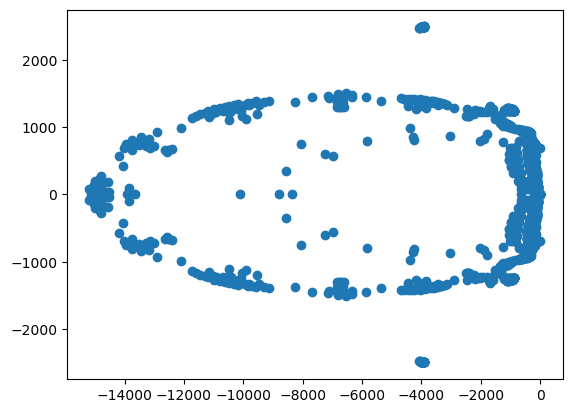

In [333]:
plt.scatter(delase.stability_params.cpu(), delase.freqs.cpu())

In [334]:
delase.filter_chrootschroots(500)

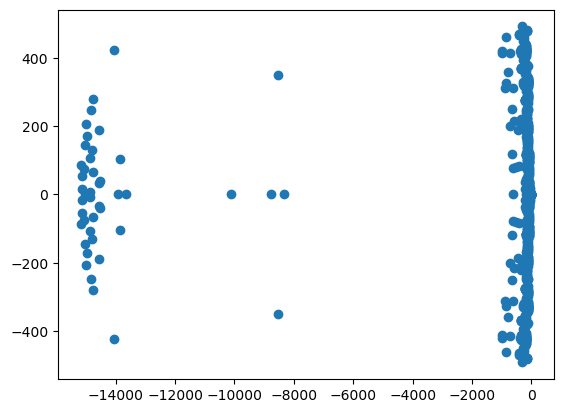

In [335]:
plt.scatter(delase.stability_params.cpu(), delase.freqs.cpu())

# CPU vs CUDA

In [7]:
signal = lfp[:15000, :64]

In [8]:
# %%time
# delase = DeLASE(signal, p=93, dt=dt, svd=True, use_torch=True, device='cpu')
# delase.compute_havok_dmd(r_thresh=0.3, lamb=0.001)
# delase.compute_jacobians()
# delase.get_stability(max_freq=500)

In [15]:
%%time
delase_cuda = DeLASE(signal, p=93, dt=dt, use_torch=True, device='cuda')
delase_cuda.compute_havok_dmd(r_thresh=0.3, lamb=0.001)
delase_cuda.compute_jacobians()
delase_cuda.get_stability(max_freq=500)

CPU times: user 2min 18s, sys: 18.4 s, total: 2min 37s
Wall time: 1min 44s


In [13]:
# %%time
# delase.compute_havok_dmd(r_thresh=0.3, lamb=0.001)
# delase.compute_jacobians()
# delase.get_stability(max_freq=500)

In [53]:
test_data = torch.from_numpy(lfp[15000 - delase_cuda.p:20000, :64]).to(delase_cuda.device)

In [198]:
%%time
ip, performance_curve, reseed_vals = compute_integrated_performance(delase_cuda, test_data, verbose=True, return_curve=True, **{})

  0%|          | 0/17 [00:00<?, ?it/s]

CPU times: user 18.8 s, sys: 6.1 s, total: 24.9 s
Wall time: 20.3 s


In [262]:
def sizeof(obj):
    size = sys.getsizeof(obj)
    if isinstance(obj, dict): return size + sum(map(sizeof, obj.keys())) + sum(map(sizeof, obj.values()))
    if isinstance(obj, (list, tuple, set, frozenset)): return size + sum(map(sizeof, obj))
    return size

In [264]:
sizeof(delase_cuda.__dict__)

3582

In [280]:
n_gb = 0
for key, value in delase_cuda.__dict__.items():
    if isinstance(value, torch.Tensor):
        n_gb += value.cpu().numpy().nbytes/1e9
    else:
        print(key, value)
#     delase_cuda.__dict__['data']

window 15000
n 64
p 93
tau 1
use_torch True
device cuda:0
dt 0.001
N_time_bins 93


In [296]:
delase_cuda.r

tensor(2755, device='cuda:0')

In [295]:
compute_integrated_performance(delase_cuda, test_signal, reseed_vals=ParameterGrid().reseed_vals,full_return=True)

{'ip': 0.674045655965805,
 'performance_curve': array([0.99840146, 0.98681414, 0.97138613, 0.95545626, 0.934122  ,
        0.9044632 , 0.88947475, 0.8667648 , 0.7641845 , 0.715945  ,
        0.79918855, 0.6786899 , 0.6385448 , 0.5949846 , 0.57855225,
        0.69697404, 0.609967  ], dtype=float32),
 'reseed_vals': array([   1,    5,   10,   15,   20,   30,   40,   50,  100,  150,  200,
         250,  300,  400,  500,  750, 1000]),
 'all_metric_vals': [{'autocorrel_correl': 0.99974114,
   'fft_correl': 0.9986640785785539,
   'fft_r2': 0.9967990858508315},
  {'autocorrel_correl': 0.9983809,
   'fft_correl': 0.9897430304515328,
   'fft_r2': 0.9723185641218967},
  {'autocorrel_correl': 0.99418414,
   'fft_correl': 0.9784039321651076,
   'fft_r2': 0.9415703766967332},
  {'autocorrel_correl': 0.990271,
   'fft_correl': 0.9682952398762862,
   'fft_r2': 0.9078025630200312},
  {'autocorrel_correl': 0.9810771,
   'fft_correl': 0.9527521876015774,
   'fft_r2': 0.8685367441358378},
  {'autocorrel_

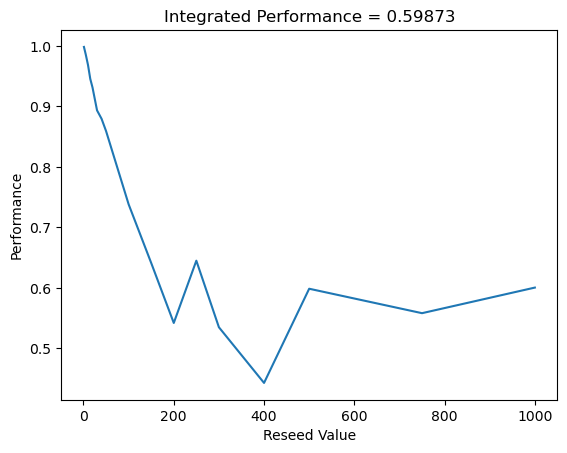

In [196]:
plt.plot(reseed_vals, performance_curve)
plt.xlabel('Reseed Value')
plt.ylabel('Performance')
plt.title(f'Integrated Performance = {ip:.5f}')
plt.show()

In [192]:
reseed = 100
pred_data = delase_cuda.predict_havok_dmd(test_data, tail_bite=True, reseed=reseed)

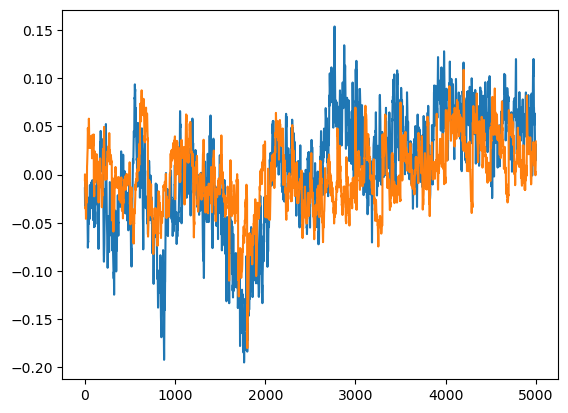

In [193]:
start = 0
end = test_data.shape[0] - delase_cuda.p
index = 0
plt.plot(test_data[delase_cuda.p + start:delase_cuda.p + end, index].cpu())
plt.plot(pred_data[delase_cuda.p + start:delase_cuda.p + end, index].cpu())
plt.show()

# Parameter Choosing

In [7]:
train_signal = lfp[:15000, :64]
test_signal = lfp[15000:20000, :64]

In [8]:
# pd.to_pickle(train_signal, '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/data/train.pkl')
# pd.to_pickle(test_signal, '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/data/test.pkl')

In [9]:
# window_vals = np.array([15000])
# p_vals = np.array([93])
# parameter_grid = ParameterGrid(window_vals=window_vals, p_vals=p_vals)

# parameter grid
window_vals = np.array([10000])
p_vals = np.array([50, 60, 70, 80, 90, 100])
# r_thresh_vals=np.array([0.3, 0.4, 0.5])
r_thresh_vals = np.array([0.25, 0.5])
# lamb_vals = np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1])
lamb_vals = np.array([0, 1e-3])
reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
parameter_grid = ParameterGrid(window_vals, p_vals, r_thresh_vals, lamb_vals, reseed_vals)

In [10]:
results = parameter_search(train_signal, test_signal, parameter_grid, dt=dt, use_torch=True, device='cuda', verbose=True, track_reseeds=True)

  0%|          | 0/408 [00:00<?, ?it/s]

In [288]:
# results_save = pd.to_pickle(results, '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp/param_search.pkl')

In [240]:
max_row = results.iloc[results.integrated_performance.argmax()]

In [245]:
norm = Normalize(vmin=results.integrated_performance.min(), vmax=results.integrated_performance.max())

In [251]:
cmap = get_cmap('plasma')

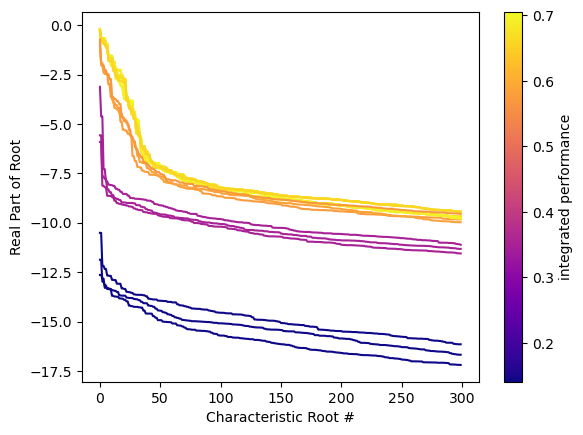

In [256]:
for i in range(len(results)):
    plt.plot(results.iloc[i].stability_params.cpu().numpy()[:300], c=cmap(norm(results.iloc[i].integrated_performance)))
plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), label='integrated performance')
plt.xlabel('Characteristic Root #')
plt.ylabel('Real Part of Root')
plt.show()

In [257]:
torch.cuda.device_count()

1